## Plot bias correction maps, with observation site bias overlaid
Last updated: Kevin Varga, 12/27/2024

**Inputs:**
* Netcdf of modeled LFM values
* CSV of observed and bias corrected LFM at all sites
* CSV of locations of LFM observations

**Outputs:**
* Map of bias correction at individual time steps

In [25]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import cartopy.io.shapereader as shpreader

In [26]:
# Set paths
grid_path = '/home/sbarc/students/varga/nasa/ch1/data/lfm_model/'
bc_path = '/home/sbarc/students/varga/nasa/ch1/data/bias_correction/'
shp_path = '/home/sbarc/students/varga/nasa/data/shapefiles/'
obs_path = '/home/sbarc/students/varga/nasa/ch1/data/lfm_obs/'
output_path = '/home/sbarc/students/varga/nasa/ch1/figures/lfm_maps/bias_correction/'

In [27]:
# Read in county shapefile
counties_shp = cfeature.ShapelyFeature(shpreader.Reader(shp_path + 'ca_counties.shp').geometries(),
                                       ccrs.PlateCarree(), edgecolor='black', facecolor='none')

In [28]:
# Open LFM dataset and create bias correction data array
lfm_ds = xr.open_dataset(grid_path + 'sba_lfm_1987-2019.nc')
da_correction = lfm_ds['chamise'] - lfm_ds['chamise_no_bias_correction']

In [29]:
# Read in chamise LFM observations, predictions and bias corrections at observation sites
predict_df = pd.read_csv(bc_path + '30_model_output.csv', index_col=[0,1], parse_dates=True, infer_datetime_format=True)
# Read in csv that contains lat/lon of observation sites
obs_df = pd.read_csv(obs_path + 'lfm_crop_site_loc.csv', index_col='site')

# Extract site names
sites = pd.unique(predict_df.index.get_level_values(0))
# Subset observation locations to only chamise sites
obs_df = obs_df[obs_df.index.isin(sites)]
# Extract dates
dates = pd.unique(predict_df.index.get_level_values(1))

# Map lat/lon of each site observation to site names in predict_df
lats_map = dict(zip(obs_df.index, obs_df['latitude']))
lons_map = dict(zip(obs_df.index, obs_df['longitude']))
predict_df.loc[:, 'latitude'] = predict_df.index.get_level_values(0).map(lats_map)
predict_df.loc[:, 'longitude'] = predict_df.index.get_level_values(0).map(lons_map)

# Calculate correction factor at each site
predict_df.loc[:, 'correction'] = predict_df['corrected'] - predict_df['predicted']

In [30]:
# Determine time step of largest positive and negative bias
max_values = da_correction.max(dim=['latitude','longitude'])
min_values = da_correction.min(dim=['latitude','longitude'])
print(f'Most negative bias time step: {min_values.argmin().values} \n', 
      f'Most positive bias time step: {max_values.argmax().values}')

Most negative bias time step: 249 
 Most positive bias time step: 416


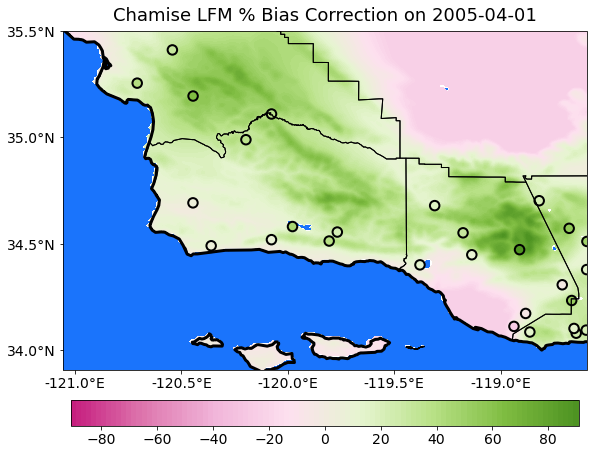

In [31]:
# Set fuel type and time step
fuel_type = 'chamise'
i = 416
fuel_title = 'Chamise LFM % Bias Correction on '

# Set desired latitude and longitude map ticks
lon_ticks = [-119, -119.5, -120, -120.5, -121]
lat_ticks = [34, 34.5, 35, 35.5]

# Extract LFM dataset dimensions
lat = lfm_ds['latitude'].to_numpy()
lon = lfm_ds['longitude'].to_numpy()
times = lfm_ds['time'].to_numpy()

# Extract max/min bias correction values and create colormap levels
min_value = round(da_correction.isel(time=i).min().to_numpy().item())
max_value = round(da_correction.isel(time=i).max().to_numpy().item())
# Use the larger of max or min as extreme in order to have divergent color map
if abs(min_value) > max_value:
    largest_value = abs(min_value)
else:
    largest_value = max_value
cmap_levels = np.round(np.linspace(-largest_value, largest_value, 101))

# Define custom colormap
# LFM color map
#colors = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#c7eae5', '#80cdc1', '#35978f', '#01665e']
# Bias correction color map
#colors = ['#c51b7d','#de77ae','#f1b6da','#fde0ef','#f7f7f7','#e6f5d0','#b8e186','#7fbc41','#4d9221']
colors = ['#c51b7d','#de77ae','#f1b6da','#fde0ef','#e6f5d0','#b8e186','#7fbc41','#4d9221']
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

#for time_stamp in times:

# Select a specific time stamp 
lfm_values = da_correction.isel(time = i)

# Mask out ocean values
mask = np.isnan(lfm_values.to_numpy())
masked_data = np.array([[1 if np.isnan(val) else np.nan for val in row] for row in lfm_values.to_numpy()])

# Create a plot
fig = plt.figure(figsize=(14, 8), facecolor='white')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
# Add coastline and county lines
ax.coastlines(linewidth=3)
ax.add_feature(counties_shp)

# Add the latitude and longitude tickmarks
ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{l:.1f}°E' for l in lon_ticks], fontsize=14)
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{l:.1f}°N' for l in lat_ticks], fontsize=14)

# Plot chamise values
im = plt.contourf(lon, lat, lfm_values, transform=ccrs.PlateCarree(), 
                  cmap=cmap, levels=cmap_levels, vmin=-largest_value, vmax=largest_value)

# Adjust colorbar
cbar = plt.colorbar(im, pad = 0.07, shrink = 0.65, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)

# Plot masked_data in blue for ocean values
oc = plt.contourf(lon, lat, masked_data, transform=ccrs.PlateCarree(), colors='#0165fc', alpha=0.9);

# Subset LFM observation site bias corrections at time step
site_corrections = predict_df.xs(dates[i], level=1).loc[:,['latitude','longitude','correction']]
# Plot the point with color based on correction value
ax.scatter(site_corrections['longitude'], site_corrections['latitude'], c=site_corrections['correction'], 
           cmap=cmap, transform=ccrs.PlateCarree(), edgecolors='black', s=90, linewidth=2,
           vmin=-largest_value, vmax=largest_value)

# Select individual time stamp for title
time_stamp = da_correction['time'][i].to_numpy()
plt.title(fuel_title + str(time_stamp).split('T')[0], fontsize=18, pad=10);
# Show and save
plt.show();
fig.savefig(output_path + str(time_stamp).split('T')[0],
            dpi = 600, bbox_inches='tight');
#plt.close()